In [23]:
from main import Unsupervised_FF, train, plot_loss
import torch, torchvision
from torch.utils.data import DataLoader
from torch.nn.functional import cosine_similarity
from utils import prepare_data

In [4]:
prepare_data()

# Load the MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
pos_dataset = torchvision.datasets.MNIST(root='./', download=False, transform=transform, train=True)
# pos_dataset = Subset(pos_dataset, list(range(1000)))
# Create the data loader
pos_dataloader = DataLoader(pos_dataset, batch_size=64, shuffle=True, num_workers=4)

# Load the transformed images
neg_dataset = torch.stack(torch.load('transformed_dataset.pt'))
# Create the data loader
neg_dataloader = DataLoader(neg_dataset, batch_size=64, shuffle=True, num_workers=4)

# Load the test images
test_dataset = torchvision.datasets.MNIST(root='./', train=False, download=False, transform=transform)
# Create the data loader
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

100%|██████████| 60000/60000 [00:29<00:00, 2027.37it/s]


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unsupervised_ff = Unsupervised_FF(device=device, n_epochs=10)

loss = train(unsupervised_ff, pos_dataloader, neg_dataloader)

Training Last Layer: 100%|██████████| 10/10 [00:40<00:00,  4.09s/it]


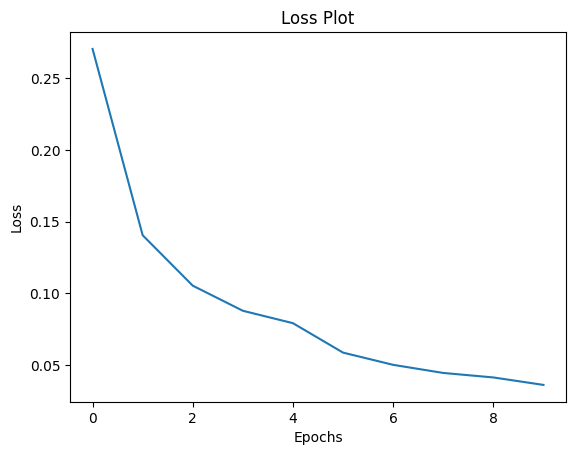

In [7]:
plot_loss(loss)

In [8]:
unsupervised_ff.evaluate(pos_dataloader, dataset_type="Train")
unsupervised_ff.evaluate(test_dataloader, dataset_type="Test")

Train dataset scores:  accuracy_score: 0.9854833333333334


Test dataset scores:  accuracy_score: 0.958


In [9]:
from tqdm import tqdm
inner_tqdm = tqdm(test_dataloader, desc=f"Evaluating model", leave=False, position=1)
all_encodings = []
for image, labels in inner_tqdm:
    image = image[0].to(unsupervised_ff.device)
    all_encodings.append(unsupervised_ff.encoding(image).detach().cpu())

all_encodings = torch.stack(all_encodings)


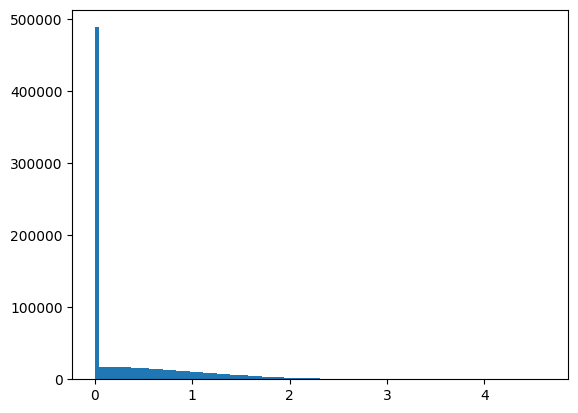

tensor(2122.1580)
torch.Size([1, 1, 6000])


In [10]:
from matplotlib import pyplot as plt
from traitlets import All   
plt.hist(all_encodings.flatten().numpy(), bins=100)
plt.show()
print(sum(all_encodings[0][all_encodings[0] > 0.5]))
print(all_encodings[0].shape)

In [17]:
def get_weights(model):
    weights = {}
    for idx, layer in enumerate(model.ff_layers):
        weights[f"layer_{idx}"] = layer.weight.data
    weights["last_layer"] = model.last_layer.weight.data
    return weights

In [18]:
print(get_weights(unsupervised_ff))

{'layer_0': tensor([[ 0.0213, -0.0284, -0.0313,  ...,  0.0215,  0.0284, -0.0015],
        [-0.0217, -0.0294, -0.0176,  ...,  0.0296, -0.0089,  0.0287],
        [-0.0160,  0.0235,  0.0053,  ...,  0.0085,  0.0165, -0.0109],
        ...,
        [ 0.0144,  0.0250,  0.0073,  ...,  0.0203,  0.0305, -0.0120],
        [-0.0126, -0.0063, -0.0149,  ...,  0.0141,  0.0081,  0.0058],
        [ 0.0343, -0.0228, -0.0116,  ..., -0.0253,  0.0316,  0.0011]],
       device='cuda:0'), 'layer_1': tensor([[-0.0146,  0.0037,  0.0148,  ...,  0.0142,  0.0210,  0.0214],
        [-0.0050,  0.0075, -0.0166,  ...,  0.0141, -0.0013,  0.0014],
        [ 0.0130,  0.0066, -0.0091,  ...,  0.0051, -0.0221, -0.0064],
        ...,
        [ 0.0124,  0.0007,  0.0009,  ...,  0.0216, -0.0017,  0.0115],
        [-0.0092,  0.0001,  0.0143,  ...,  0.0087, -0.0044, -0.0099],
        [ 0.0181,  0.0019, -0.0067,  ..., -0.0012, -0.0119, -0.0172]],
       device='cuda:0'), 'layer_2': tensor([[-0.0214, -0.0156, -0.0066,  ...,  0.005

In [39]:
def get_sparse_representation(model, image):
    encodings = model.encoding(image)
    return encodings.reshape(-1).detach()

In [44]:
sparse_representations = [[] for _ in range(10)]
for x_batch, y_batch in test_dataloader:
    for x, y in zip(x_batch, y_batch):
        sparse_representations[y.item()].append(get_sparse_representation(unsupervised_ff, x))
print(sparse_representations[0][0].shape)

similarities = [[] for _ in range(10)]
for i in range(10):
    for j in range(len(sparse_representations[i])):
        for k in range(j+1, len(sparse_representations[i])):
            similarity = cosine_similarity(sparse_representations[i][j].unsqueeze(0), sparse_representations[i][k].unsqueeze(0))
            similarities[i].append(similarity.item())

torch.Size([6000])


In [46]:
for i in range(10):
    average_similarity = sum(similarities[i]) / len(similarities[i])
    print(f"Average similarity for digit {i}: {average_similarity}")

Average similarity for digit 0: 0.765185223718946
Average similarity for digit 1: 0.7722111258162676
Average similarity for digit 2: 0.740092381753419
Average similarity for digit 3: 0.7628460039783324
Average similarity for digit 4: 0.750099019663492
Average similarity for digit 5: 0.7235855768983566
Average similarity for digit 6: 0.7603579927970696
Average similarity for digit 7: 0.7554080380172303
Average similarity for digit 8: 0.7645339709214588
Average similarity for digit 9: 0.7689294992071465
